In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
from IPython.display import clear_output
!pip3 install -U lazypredict
!pip3 install -U pandas
clear_output()

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [4]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split

In [5]:
from lightgbm import LGBMClassifier
import lazypredict
from lazypredict.Supervised import LazyClassifier
import time
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


# 데이터 불러오기

In [6]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

RANDOM_STATE = 12
FOLDS = 5
STRATEGY = 'median'

- 데이터 확인

In [7]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.00,False,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.00,False,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.00,True,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.00,False,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.00,False,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [8]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

-- 결측치가 존재한다

In [9]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.00,8512.00,8510.00,8485.00,8510.00,8505.00
mean,28.83,224.69,458.08,173.73,311.14,304.85
std,14.49,666.72,1611.49,604.70,1136.71,1145.72
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,27.00,0.00,0.00,0.00,0.00,0.00
75%,38.00,47.00,76.00,27.00,59.00,46.00
max,79.00,14327.00,29813.00,23492.00,22408.00,24133.00


- - test data

In [10]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.00,False,0.00,0.00,0.00,0.00,0.00,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.00,False,0.00,9.00,0.00,2823.00,0.00,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.00,False,0.00,0.00,0.00,0.00,0.00,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.00,False,0.00,6652.00,0.00,181.00,585.00,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.00,False,10.00,0.00,635.00,0.00,0.00,Brence Harperez


In [11]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [12]:
test.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.00,4195.00,4171.00,4179.00,4176.00,4197.00
mean,28.66,219.27,439.48,177.30,303.05,310.71
std,14.18,607.01,1527.66,560.82,1117.19,1246.99
min,0.00,0.00,0.00,0.00,0.00,0.00
25%,19.00,0.00,0.00,0.00,0.00,0.00
50%,26.00,0.00,0.00,0.00,0.00,0.00
75%,37.00,53.00,78.00,33.00,50.00,36.00
max,79.00,11567.00,25273.00,8292.00,19844.00,22272.00


-EDA

-- 데이터 분석에 상관이 없는 승객 id 제거 (훈련 데이터와 테스트 데이터 동일하게 작업)

In [13]:
train.drop(['PassengerId'],axis = 1, inplace = True)
test.drop(['PassengerId'],axis = 1, inplace = True)

In [14]:
TARGET = 'Transported'
# id 랑 타겟 제외한 컬럼
FEATURES = [col for col in train.columns if col not in ['id', TARGET]]

--- 
훈련 데이터 중에서 수치가 숫자형인 특성들의 정보 시각화

In [15]:
train.iloc[:, :-1].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
FoodCourt,8510.00,458.08,1611.49,0.00,0.00,0.00,76.00,29813.00
VRDeck,8505.00,304.85,1145.72,0.00,0.00,0.00,46.00,24133.00
Spa,8510.00,311.14,1136.71,0.00,0.00,0.00,59.00,22408.00
RoomService,8512.00,224.69,666.72,0.00,0.00,0.00,47.00,14327.00
ShoppingMall,8485.00,173.73,604.70,0.00,0.00,0.00,27.00,23492.00
Age,8514.00,28.83,14.49,0.00,19.00,27.00,38.00,79.00


df.T는 행과 열을 변환 -> 즉 숫자형의 특성의 describe 결과표의 행과 열을 바꿔서 반환한다.

그리고 std을 기준으로 내림차순으로 정렬하고  각 특성의 최댓값과 평균을 바 형태로 출력하여 보기 좋게 한다.

푸드코드 이용수가 월등하게 많고 그 다음으로 VRDeck와 spa가 비슷한 평균으로 2,3위를 차지하고 그 뒤로 룸서비스, 쇼핑몰이 있다.

분산 순위대로 최대값도 비슷한데 딷 하나 쇼핑몰이 튄다.

---
특성12가지 중 2개는 텍스트, 6개는 연속적인 값, 4개는 범주형

In [16]:
# 행축으로 훈련 데이터와 테스트 데이터를 concat하여 새로운 객체 df를 만든다.
df = pd.concat([train[FEATURES], test[FEATURES]],axis = 0)
# 텍스트
text_ft = ['Cabin','Name']

# 텍스트 특징이 아니면서 걱 특성의 데이터수가 25 미만이면 범주형, 25개 이상이면 연속적인 값으로 분류
# 범주형
cat_ft = [col for col in FEATURES if df[col].nunique() < 25 and col not in text_ft]
# 연속적인 값
cont_ft = [col for col in FEATURES if df[col].nunique() >= 25 and col not in text_ft]

unique : 데이터에 고유값들이 어떤 종류들이 알고 싶을 때

uunique : 데이터의 고유값들의 수를 출력

In [17]:
cont_ft

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

In [18]:
cat_ft

['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

In [19]:
text_ft

['Cabin', 'Name']

In [20]:
labels = ['Categorical','Continous','Text']
values = [len(cat_ft),len(cont_ft),len(text_ft)]
colors = ['#E57373','#9575CD']

In [21]:
fig = go.Figure(data=[go.Pie(
    labels = labels,
    values = values,
    marker = dict(colors = colors,
                 line = dict(color = "#000000",
                            width =2))
)])
fig.show()

연속적인 값들은 갖는 컬럼들이 전체의 50이고 그 다음으로 범주형이 33이고 텍스트 컬럼이 16이다.

---
연령대 분포 시각화 (연속적인 값)

In [22]:
train_age = train.copy()
test_age = test.copy()

# 타입별로 묶어서 시각화 하기 위한 변수 생성
train_age['type'] = 'Train'
test_age['type'] = 'Test'
age = pd.concat([train_age,test_age])

In [23]:
fig = px.histogram(data_frame = age,
                  x = 'Age',
                  color = 'type',
                   marginal ='box',
                  nbins = 80)
fig.update_layout(title = 'Distribution of Age', title_x = 0.5)
fig.show()

nbin : 표본수와 비슷하게 선택된다. 전체 데이터를 몇개로 나누냐의 의미. 설정한 값과 같거나 비슷한 값으로 나뉜다.

20 ~ 40대가 많다.

---
범주형 데이터 시각화

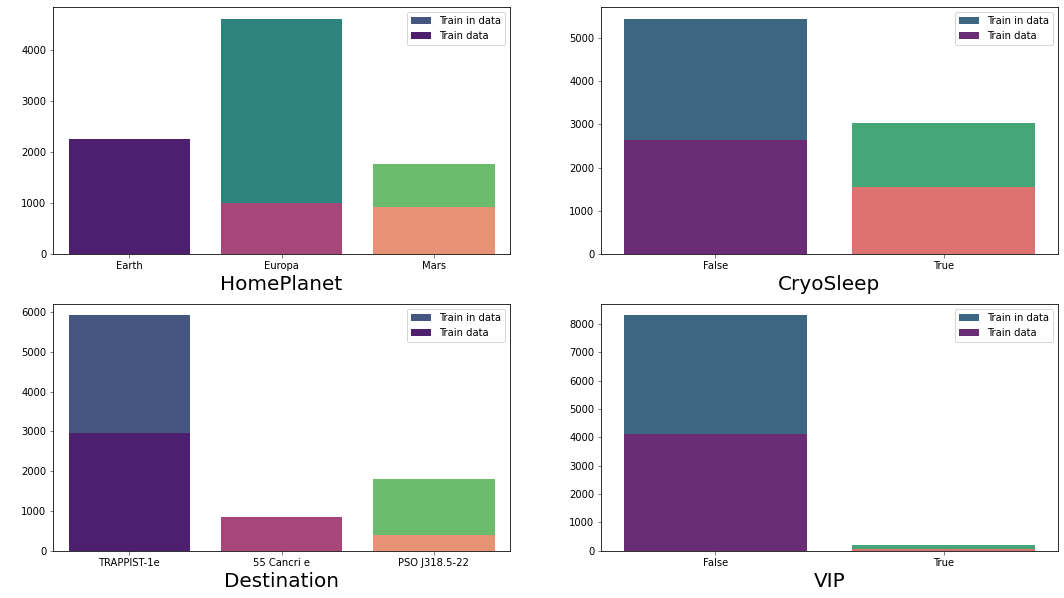

In [24]:
if len(cat_ft) == 0:
    print("No Categorial features")
else:
    # 범주형 데이터가 4개 이므로 (2,2) 형태로 그래프를 뽑는다.
    ncols = 2
    nrows = 2
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(18,10))
    for i in range(nrows):
        for j in range(ncols):
            # 자리 선정
            col = cat_ft[i * ncols + j]
            sns.countplot(train[col],ax = axes[i,j],palette = "viridis",label='Train in data')
            sns.countplot(test[col],ax = axes[i,j],palette = 'magma',label='Train data')
            axes[i,j].legend()
            axes[i,j].set_ylabel(' ')
            axes[i,j].set_xlabel(col, fontsize =20)
            axes[i,j].tick_params(labelsize=10, width=0.5)
            axes[i,j].xaxis.offsetText.set_fontsize(4)
            axes[i,j].yaxis.offsetText.set_fontsize(4)
    fig.show()

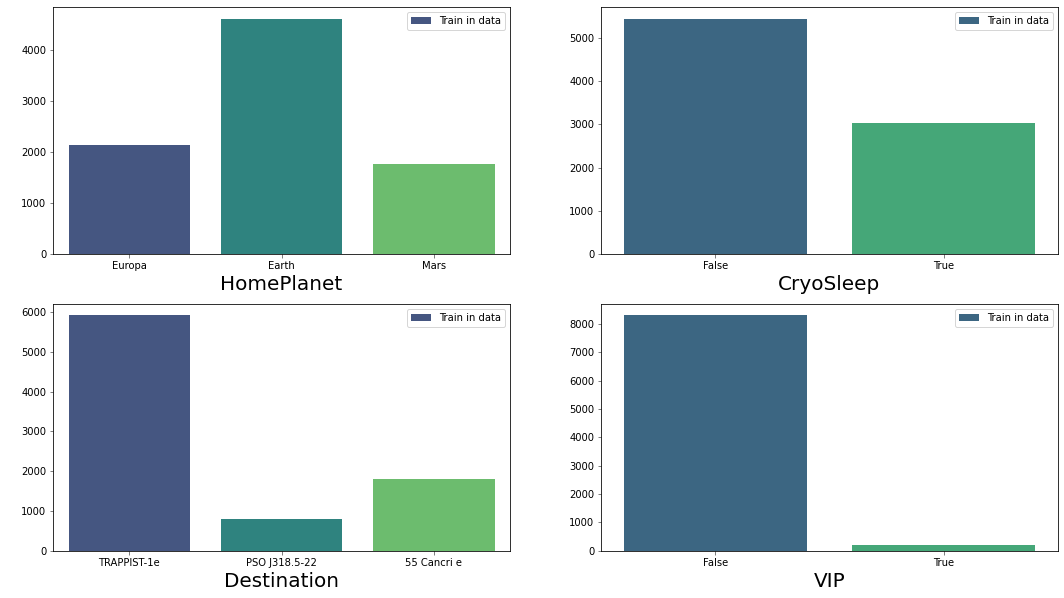

In [25]:
if len(cat_ft) == 0:
    print("No Categorial features")
else:
    # 범주형 데이터가 4개 이므로 (2,2) 형태로 그래프를 뽑는다.
    ncols = 2
    nrows = 2
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(18,10))
    for i in range(nrows):
        for j in range(ncols):
            # 자리 선정
            col = cat_ft[i * ncols + j]
            sns.countplot(train[col],ax = axes[i,j],palette = "viridis",label='Train in data')
            #sns.countplot(test[col],ax = axes[i,j],palette = 'magma',label='Train data')
            axes[i,j].legend()
            axes[i,j].set_ylabel(' ')
            axes[i,j].set_xlabel(col, fontsize =20)
            axes[i,j].tick_params(labelsize=10, width=0.5)
            axes[i,j].xaxis.offsetText.set_fontsize(4)
            axes[i,j].yaxis.offsetText.set_fontsize(4)
    fig.show()
            

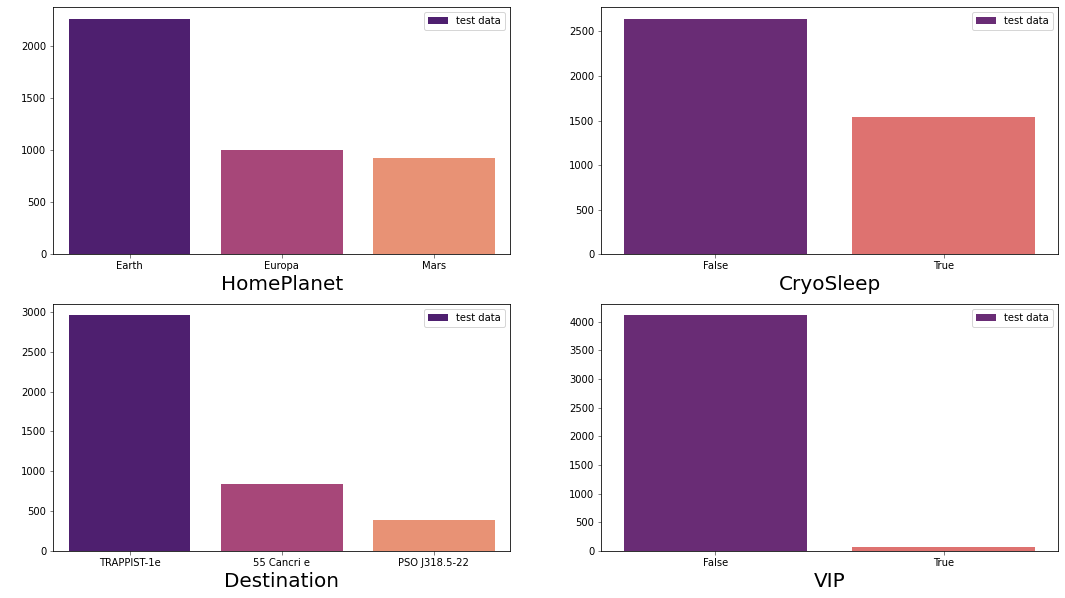

In [26]:
if len(cat_ft) == 0:
    print("No Categorial features")
else:
    # 범주형 데이터가 4개 이므로 (2,2) 형태로 그래프를 뽑는다.
    ncols = 2
    nrows = 2
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(18,10))
    for i in range(nrows):
        for j in range(ncols):
            # 자리 선정
            col = cat_ft[i * ncols + j]
            # sns.countplot(train[col],ax = axes[i,j],palette = "viridis",label='Train in data')
            sns.countplot(test[col],ax = axes[i,j],palette = 'magma',label='test data')
            axes[i,j].legend()
            axes[i,j].set_ylabel(' ')
            axes[i,j].set_xlabel(col, fontsize =20)
            axes[i,j].tick_params(labelsize=10, width=0.5)
            axes[i,j].xaxis.offsetText.set_fontsize(4)
            axes[i,j].yaxis.offsetText.set_fontsize(4)
    fig.show()

훈련데이터와 테스트 데이터에서의 범주형 컬럼 분포 비교

HomePlanet의 Earth의 train data가 존재하는지 잘 모르겠음. 나중에 plotly로 시각화해서 확인해보면 좋을 듯!!->
인 줄 알았으나 범주별 수를 찾아보니 조금있는게 아니라 테스트와 훈련 데이터를 한꺼번에 시각화 하려다가 섞인듯..

In [27]:
train['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [28]:
test['HomePlanet'].value_counts()

Earth     2263
Europa    1002
Mars       925
Name: HomePlanet, dtype: int64

---
매트릭스 보정...?

In [29]:
fig = px.imshow(train.corr(), text_auto = True, aspect = 'auto', color_continuous_scale = 'magma')
fig.show()

- 선생님 말로는 숫자형  데이터 중에서 나이빼고 나머지는 연속적인 데이터로서 역할이 아니라 그냥 양적 데이터로 측정이 된다...? 

그래서 별로 중요하지 않을 것 같다. (구매하지 않은 사람들이 더 많고 구매한 사람이 극히 일부에 지나지 않음)

-> 일단 수업시간에는 계속 참고 자료 분석하고 이후 주말동안 해서 다시 다뤄봐야 할듯

# 데이터 전처리

결측치값 처리하기 (숫자형 데이터 + home)

In [30]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer(strategy = STRATEGY)
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])

In [31]:
train['HomePlanet'].fillna('Z',inplace = True)
test['HomePlanet'].fillna('Z',inplace = True)

숫자형 데이터의 결측치는 평균값으로 채워놓고 범주형 데이터인 HomePlanet은 z로 채워넣는다.

---
범주형 데이터 처리 - 모델 학습돌리기 위해 숫자로 변환

In [32]:
label_cols= ["HomePlanet", "CryoSleep","Cabin", "Destination" ,"VIP"]

In [33]:
def label_encoder(train,test,columns):
    for col in columns:
        train[col] = train[col].astype(str)
        test[col] = test[col].astype(str)
        train[col] = LabelEncoder().fit_transform(train[col])
        test[col] = LabelEncoder().fit_transform(test[col])
    return train, test

In [34]:
train, test = label_encoder(train,test,label_cols)

논리형 값들을 str로 문자열로 바꾸 범주형 데이터와 같이 처리한다.

그리고 다시 문자열 데이터를 숫자형 데이터로 바꿔준다.(LabelEncoder)

---
학습에 쓰지 않을 특성 처리

In [35]:
train.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,1,0,149,2,39.00,0,0.00,0.00,0.00,0.00,0.00,Maham Ofracculy,False
1,0,0,2184,2,24.00,0,109.00,9.00,25.00,549.00,44.00,Juanna Vines,True
2,1,0,1,2,58.00,1,43.00,3576.00,0.00,6715.00,49.00,Altark Susent,False
3,1,0,1,2,33.00,0,0.00,1283.00,371.00,3329.00,193.00,Solam Susent,False
4,0,0,2186,2,16.00,0,303.00,70.00,151.00,565.00,2.00,Willy Santantines,True


In [36]:
train.drop(["Name","Cabin"], axis = 1, inplace = True)
test.drop(["Name","Cabin"], axis = 1, inplace = True)

---
훈련데이터와 테스트 데이터 분류

In [37]:
X = train.drop(TARGET, axis = 1)
Y = train[TARGET]
X_train, Y_train, X_target, Y_target = train_test_split(X,Y,random_state = 12,test_size = 0.33)

# 모델링

## LGBMClassfier (5폴드)

- LGBM ??
    - 트리 기반 머신러닝 알고리즘
    - GBM : 틀린 부분에 가중치를 더하면서 진행하는 알고리즘
    - 수평적 확장 트리구조가 아닌 수직적 확장 트리구조 -> 속도 빠름, 큰 사이즈의 데이터를 적은 메모리로 다룰 수 있다.
    - 대신 과적합될 확률이 다른 트리 구조보다는 높다.
    

In [38]:
lgb_params = {
    'objective' : 'binary',
    'n_estimators' : 50,
    'learning_rate' : 0.08
}

- learning_rate 
    - 최종 결과에 대한 각각의 트리에 영향을 미치는 변수!!
    - 초기의 추정값에서 시작하여 각각의 트리 결과 사용하여 추정값 업뎃
    - 0.1, 0.001, 0.003 등 존재

- objective (application)
    - 가장 중요한 파라미터 
    - 모델의 어플리케이션 정한다. -> regression 회귀인지, classification 분류 문제인지 정함
    - 디폴트값 regression 회귀분석 모델
    - binary 이진분류 /  multiclass 다중 분류
  
- n_estimators
    - 생성할 트리 개수
    
- learning_rate를 작게 하면서 n_estimators크게 하는 게 부스팅 계열 튜닝에서 가장 기본적인 튜닝 방안. 그렇다고 n_estimators크게 하면 과적합 가능성 있음.
- 과적합 제어 -> regularization(reg_lambda, reg_alpha)적용
- 학습에 사용할 특성 개수나 데이터 샘플 레코드 개수 줄이기 위해서 colsample_bytree, subsample 파라미터 적용 가능

In [39]:
lgb_predictions = 0
lgb_scores = []
lgb_fimp =[]

In [40]:
train.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported'],
      dtype='object')

In [41]:
# 타겟 특성 뺀 컬럼 따로 저장
LGBM_FEATURES = list(train.columns)[:-1]
skf = StratifiedKFold(n_splits = FOLDS, shuffle = True, random_state=RANDOM_STATE)

n_splits : FOLD = 5 

- StratifiedKFold : 분할기
    - 훈련 데이터와 테스트 데이터 분할
    - 회귀 -> KFold
    - 분류 -> StratifiedKFold :  타겟에 속성값의 개수를 동일하게 가져가서 데이터가 한곳으로 몰리는것 방지
   

In [42]:
# 타겟 컬럼을 뺀 훈련 데이터 와 타겟 데이터를 split 분류하여 train_idx와 valid_idx에 저장
for fold, (train_idx, valid_idx) in enumerate(skf.split(train[LGBM_FEATURES], train[TARGET])):
    print(10*"=", f"Fold={fold+1}", 10*"=")
    # 시작 시간 저장
    start_time = time.time()
    
    # 위에서 훈련 / 테스트 별 분류된 인덱스 값을 이용해 훈련 / 테스트 데이터로 분류
    X_train, X_valid = train.iloc[train_idx][LGBM_FEATURES],train.iloc[valid_idx][LGBM_FEATURES]
    # Y_train, Y_valid = train[TARGET].iloc[train_idx],train[TARGET].iloc[valid_idx]
    Y_train, Y_valid = train.iloc[train_idx][TARGET],train.iloc[valid_idx][TARGET]
    
    # 모델 학습 (파라미터)
    model = LGBMClassifier(**lgb_params)
    model.fit(X_train, Y_train, verbose = 0)
    
    # 정확도 측정해서 저장
    preds_valid = model.predict(X_valid)
    acc = accuracy_score(Y_valid, preds_valid)
    lgb_scores.append(acc)
    
    
    run_time = time.time() - start_time
    
    # 컬럼 별 특성 중요도 
    fim = pd.DataFrame(index=LGBM_FEATURES,
                      data=model.feature_importances_,
                      columns=[f'{fold}_importance'])
    lgb_fimp.append(fim)
    
    
    print(f"Fold={fold+1}, Accuracy score : {acc :2f}%, Run Time : {run_time:2f}s")
    test_preds = model.predict(test[LGBM_FEATURES])
    lgb_predictions += test_preds/FOLDS

print("")
print("Mean Accuracy : ", np.mean(lgb_scores))
    

========== Fold=1 ==========
Fold=1, Accuracy score : 0.809086%, Run Time : 0.114708s
========== Fold=2 ==========
Fold=2, Accuracy score : 0.780334%, Run Time : 0.107909s
========== Fold=3 ==========
Fold=3, Accuracy score : 0.790109%, Run Time : 0.103036s
========== Fold=4 ==========
Fold=4, Accuracy score : 0.788838%, Run Time : 0.106702s
========== Fold=5 ==========
Fold=5, Accuracy score : 0.808400%, Run Time : 0.104815s

Mean Accuracy :  0.7953533338935979


enumerate : 열거하다/ 순서가 있는 자료형 (리스트, 셋, 튜플, 딕셔너리, 스트링)을 입력받고 인덱스 값을 포함하여 객체로 리턴

파라미터 앞 ** : * 파라미터를 몇개 받을지 모르는 경우 , 튜플 형태 / ** 파라미터명과 같이 딕셔너리 형태

verbose : 함수 수행 시 과정을 출력할지 안할지 디폴트 값 0 (안함)

accuracy_score: acc (train, valid) 정확도 측정 , 다중분류에서 주로 사용되는 듯

In [43]:
fim

,4_importance
HomePlanet,153
CryoSleep,65
Destination,60
Age,194
VIP,16
RoomService,162
FoodCourt,225
ShoppingMall,143
Spa,263
VRDeck,219


In [44]:
d = enumerate(('하나','둘','셋'))

for i, value in d:
    print(i,":", value)
print()

0 : 하나
1 : 둘
2 : 셋

